In [48]:
import json
import os
import sys

#sys.path.append('/home/luis/CGE/luxgiant-dstream/luxgiant_dstream')
sys.path.append('/mnt/0A2AAC152AABFBB7/CGE/luxgiant-dstream')

from luxgiant_dstream.prep_ds import PrepDS
from luxgiant_dstream.gwas_fixed import GWASfixed
from luxgiant_dstream.gwas_random import GWASrandom

In [49]:
params = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/parameters.JSON"))
paths = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/paths_home_local.JSON"))

#params = json.load(open("//home/luis/data/LuxGiantimputed/configFiles/parameters.JSON"))
#paths = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/paths_local.JSON"))

In [50]:
gwas_f = GWASfixed(
    input_path = paths['input_directory'],
    input_name = paths['input_prefix'],
    output_path= paths['output_directory'],
    output_name= paths['output_prefix'],
    dependables= paths['dependables_directory'],
    config_dict= params,
    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
)
gwas_f.compare_gwas_fixed_file_name = 'european_cohort_nallsEtAl2019_excluding23andMe_allVariants.hg38.tsv'
gwas_f.compare_gwas_fixed_highlights= 'highlighted_european_cohort_nallsEtAl2019_excluding23andMe_allVariants.hg38.csv'

Analysis of GWAS data using a fixed model initialized.


In [51]:
gwas_f_steps = {
    #'train_model': gwas_f.fixed_model_association_analysis,
    #'top_hits'   : gwas_f.get_top_hits,
    #'annotate'   : gwas_f.annotate_top_hits,
    #'plots'      : gwas_f.plot_drawings,
    #'one_cohort' : gwas_f.one_cohort_comparison,
    #'trumpet'     : gwas_f.create_trumpet_plot
}

for step in gwas_f_steps.keys():
    gwas_f_steps[step]()

In [52]:
import pandas as pd
import gwaslab as gl

path_2_gwas = "/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed"
filename = "ds_results_glm.PHENO1.glm.logistic.hybrid"

df_gwas = pd.read_csv(os.path.join(path_2_gwas, filename), sep='\t')

In [53]:
gwas_stats = gl.Sumstats(
    df_gwas[df_gwas['p']<5e-8], 
    snpid='SNP', 
    chrom='CHR', 
    pos='POS', 
    p='p', 
    build='hg38'
)

2024/10/18 12:12:36 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/18 12:12:36 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/18 12:12:36 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/18 12:12:36  -Reading columns          : CHR,POS,SNP,p
2024/10/18 12:12:36  -Renaming columns to      : CHR,POS,SNPID,P
2024/10/18 12:12:36  -Current Dataframe shape : 880  x  4
2024/10/18 12:12:36  -Initiating a status column: STATUS ...
2024/10/18 12:12:36  -Genomic coordinates are based on GRCh38/hg38...
2024/10/18 12:12:37 Start to reorder the columns...v3.4.48
2024/10/18 12:12:37  -Current Dataframe shape : 880 x 5 ; Memory usage: 19.98 MB
2024/10/18 12:12:37  -Reordering columns to    : SNPID,CHR,POS,P,STATUS
2024/10/18 12:12:37 Finished reordering the columns.
2024/10/18 12:12:37  -Column  : SNPID  CHR    POS   P       STATUS  
2024/10/18 12:12:37  -DType   : object string int64 float64 category
2024/10/18 12:12:37  -Verified: T      

In [54]:
gwas_stats.data['CHR'] = gwas_stats.data['CHR'].astype(int)
#high_density = ['rs9276136', 'rs2227131', 'rs2227130', 'rs2227129', 'rs9276133']
#gwas_stats.data = gwas_stats.data[~(gwas_stats.data['SNPID'].isin(high_density))].reset_index(drop=True)
gwas_stats.data

,SNPID,CHR,POS,P,STATUS
359895,rs12748961,1,205707135,6.926230e-09,3899999
359896,rs3747973,1,205708020,7.029820e-11,3899999
359897,rs3747972,1,205708207,4.285000e-09,3899999
359905,rs3805,1,205714227,4.224330e-09,3899999
359908,rs823092,1,205718745,2.096470e-08,3899999
...,...,...,...,...,...
5902418,rs5751069,22,41231771,2.488740e-08,3899999
5902419,rs9611522,22,41231920,8.223310e-09,3899999
5902427,rs4820434,22,41241115,1.313190e-08,3899999
5902531,rs9611549,22,41309905,4.954790e-08,3899999


In [55]:
def process_density(sumstats: pd.DataFrame, bwindowsizekb: int, chrom: str, pos: str):
    
    from gwaslab.viz_aux_quickfix import _get_largenumber

    # Generate a large number for scaling
    large_number = _get_largenumber(sumstats[pos].max(), log=None)
    
    # Create 'TCHR+POS' by combining chrom and pos
    sumstats["TCHR+POS"] = sumstats[chrom] * large_number + sumstats[pos]
    
    # Sort by 'TCHR+POS'
    sumstats = sumstats.sort_values(by="TCHR+POS")
    
    # Initialize the density column
    sumstats["DENSITY"] = 0
    
    # Calculate the window size in the same unit as 'TCHR+POS'
    window_size = 1000 * bwindowsizekb

    # Use a rolling window approach to count the number of SNPs within the window
    for idx, row in sumstats.iterrows():
        # Create a mask for rows within the window
        within_window = (sumstats["TCHR+POS"] >= (row["TCHR+POS"] - window_size)) & (sumstats["TCHR+POS"] < row["TCHR+POS"])
        
        # Calculate density for the current row
        density_count = within_window.sum()
        
        # Update density for the current row and all rows within the window
        sumstats.loc[within_window, "DENSITY"] += 1
        sumstats.loc[idx, "DENSITY"] += density_count

    # Compute mean and median density
    bmean = sumstats["DENSITY"].mean()
    bmedian = sumstats["DENSITY"].median()

    return sumstats, bmean, bmedian

def shrink_high_density(series:pd.Series, cutfactor:float, cut, skip, ylabels, cut_log, lines_to_plot:list):
    
    import numpy as np
        
    if ylabels is not None:
        ylabels = pd.Series(ylabels)

    series = series.copy()
    
    maxy = series.max()
    
    maxticker=int(np.round(series.max(skipna=True)))
    
    if cut:
        # auto mode : determine curline and cut factor
        if cut==True:
            if maxy<30:
                cut=0
            else:
                cut = 20
                cutfactor = ( maxy - cut )/8
        
        if cut:
            #cut log mode
            if cut_log==True:
                maxticker=int(np.round(series.max(skipna=True)))
                
                amp = (cut - skip)/ 2 / np.log2(maxticker/cut)
                
                # scaled_P
                series[series>cut] = (np.log2(series[series>cut]/cut)) * amp + cut
                
                # y labels
                if ylabels is not None:
                    ylabels[ylabels>cut] = (np.log2(ylabels[ylabels>cut]/cut)) * amp +cut 
                
                # lines
                lines_to_plot[lines_to_plot>cut] = (np.log2(lines_to_plot[lines_to_plot>cut]/cut)) * amp +cut 
                
                maxy = (np.log2(maxticker) - np.log2(cut)) * amp + cut
            else:
                #cut linear mode
                maxticker=int(np.round(series.max(skipna=True)))

                series[series>cut] = np.round((series[series>cut]-cut)/cutfactor+cut,0)
                
                if ylabels is not None:
                    ylabels[ylabels>cut] = (ylabels[ylabels>cut]-cut)/cutfactor+cut
                
                lines_to_plot[lines_to_plot>cut] = (lines_to_plot[lines_to_plot>cut]-cut)/cutfactor+cut
                #sumstats.loc[sumstats["scaled_P"]>cut,"scaled_P"] = (sumstats.loc[sumstats["scaled_P"]>cut,"scaled_P"]-cut)/cutfactor +  cut
                
                maxy = (maxticker-cut)/cutfactor + cut
    
    return series, maxy, maxticker, cut, cutfactor,ylabels,lines_to_plot

In [56]:
gwas_stats.data, bmean, bmedian = process_density(gwas_stats.data, 100, 'CHR', 'POS')
gwas_stats.data

,SNPID,CHR,POS,P,STATUS,TCHR+POS,DENSITY
359895,rs12748961,1,205707135,6.926230e-09,3899999,10205707135,87
359896,rs3747973,1,205708020,7.029820e-11,3899999,10205708020,88
359897,rs3747972,1,205708207,4.285000e-09,3899999,10205708207,89
359905,rs3805,1,205714227,4.224330e-09,3899999,10205714227,90
359908,rs823092,1,205718745,2.096470e-08,3899999,10205718745,90
...,...,...,...,...,...,...,...
5902418,rs5751069,22,41231771,2.488740e-08,3899999,220041231771,28
5902419,rs9611522,22,41231920,8.223310e-09,3899999,220041231920,28
5902427,rs4820434,22,41241115,1.313190e-08,3899999,220041241115,26
5902531,rs9611549,22,41309905,4.954790e-08,3899999,220041309905,15


In [58]:
import numpy as np

lines_to_plot = pd.Series([5e-8, 5e-6] )

results = shrink_high_density(
    series = gwas_stats.data["DENSITY"], 
    cut=True,
    skip=0,
    cutfactor = 10,
    ylabels=None,
    cut_log = False,
    lines_to_plot=-np.log10(lines_to_plot),
)

gwas_stats.data["DENSITY"], maxy, maxticker, cut, cutfactor,ylabels_converted, lines_to_plot = results

In [59]:
lines_to_plot

0    7.30103
1    5.30103
dtype: float64

2024/10/18 12:12:55 Start to create MQQ plot...v3.4.48:
2024/10/18 12:12:55  -Genomic coordinates version: 38...
2024/10/18 12:12:55  -Genome-wide significance level to plot is set to 5e-08 ...
2024/10/18 12:12:55  -Raw input contains 880 variants...
2024/10/18 12:12:55  -MQQ plot layout mode is : b
2024/10/18 12:12:55 Finished loading specified columns from the sumstats.
2024/10/18 12:12:55 Start data conversion and sanity check:
2024/10/18 12:12:55  -Removed 0 variants with nan in CHR or POS column ...
2024/10/18 12:12:55  -Removed 0 variants with CHR <=0...
2024/10/18 12:12:55  -DENSITY column exists. Skipping calculation...
2024/10/18 12:12:55  -Converting data above cut line...
2024/10/18 12:12:55  -Maximum DENSITY value is 28 .
2024/10/18 12:12:55  -Cut Auto mode is activated...
2024/10/18 12:12:55  - maxy <30 , no need to cut.
2024/10/18 12:12:55 Finished data conversion and sanity check.
2024/10/18 12:12:55 Start to create MQQ plot with 880 variants...
2024/10/18 12:12:55  -Cre

(<Figure size 6000x2000 with 1 Axes>, <gwaslab.g_Log.Log at 0x7f43aa35ed70>)

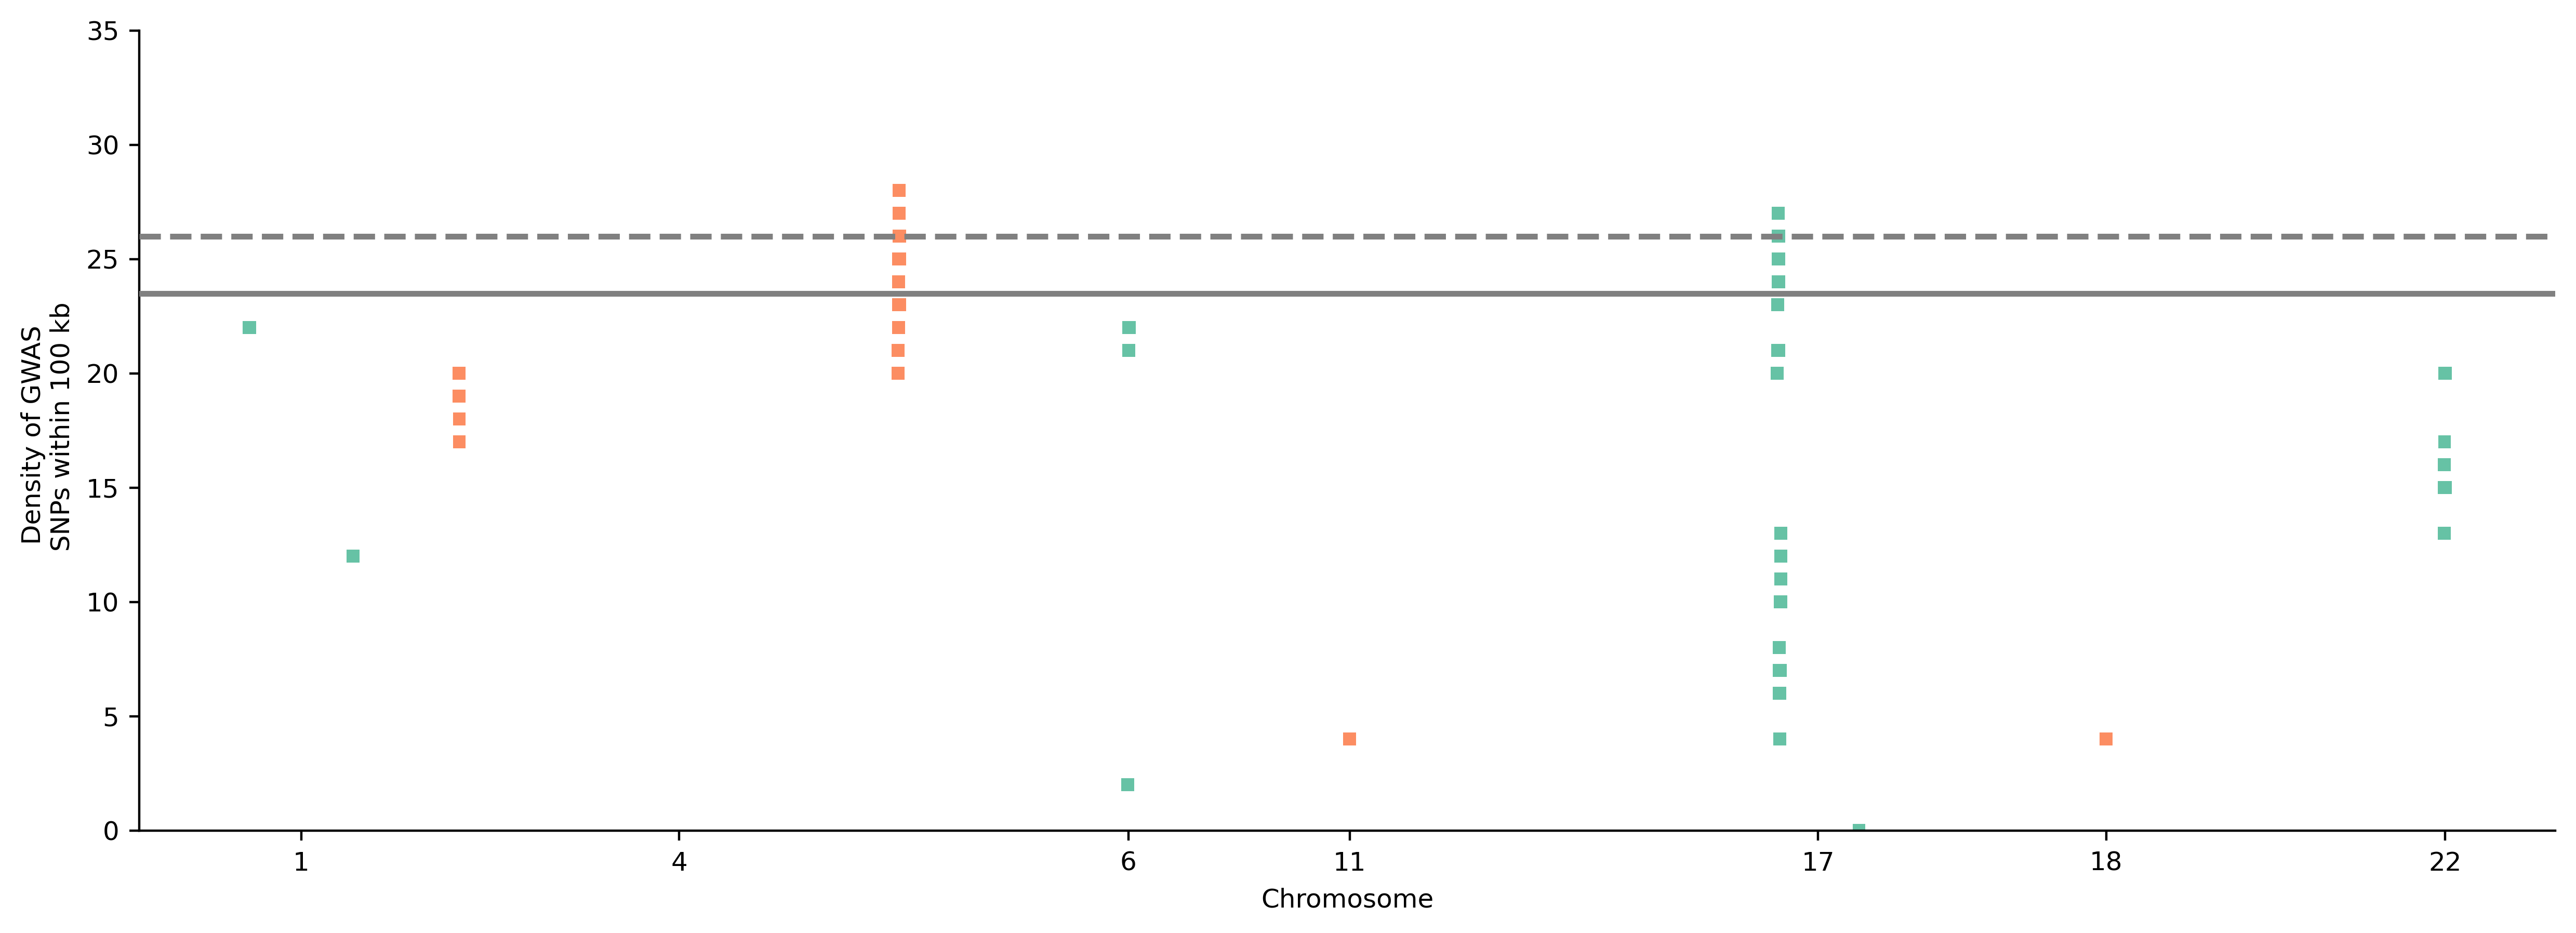

In [60]:
params = {
    'fig_args':{'figsize':(45,14)},
    'dpi':400,
    'colors':['#66c2a5', '#fc8d62'],
    'ylabels':ylabels_converted,
}
gwas_stats.plot_mqq(mode='b', font_family='DejaVu Sans', cut=True, **params)

In [61]:
df_test = pd.read_csv('/home/luisggon/Pictures/41586_2022_5275_MOESM3_ESM.csv', sep='\t')
df_test.columns
df_test[' BP (HG19) '] = df_test[' BP (HG19) '].apply(lambda x: int(x.replace(' ', '').replace('.', '')))

In [62]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12111 entries, 0 to 12110
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Locus                                     12111 non-null  object
 1   Chr                                       12111 non-null  int64 
 2   SNP                                       12111 non-null  object
 3    BP (HG19)                                12111 non-null  int64 
 4    BP (HG38)                                12111 non-null  object
 5   Effect Allele (A1)                        12111 non-null  object
 6   A1 Frequency                              12111 non-null  object
 7   Marginal effect size (b)                  12111 non-null  object
 8   b SE                                      12111 non-null  object
 9   b P-value                                 12111 non-null  object
 10   Per SNP sample size                      1211

In [63]:
#sumstats = gl.Sumstats(df_test,snpid="SNP",chrom="Chr",pos=" BP (HG19) ",p="b P-value")

In [64]:
#sumstats.plot_mqq(mode="b")

In [65]:

cut=20
cutfactor=36.5
series = gwas_stats.data["DENSITY"]
series

359895     22
359896     22
359897     22
359905     22
359908     22
           ..
5902418    20
5902419    20
5902427    20
5902531    15
5902532    15
Name: DENSITY, Length: 880, dtype: int64

In [66]:
import numpy as np
series[series>cut] = np.round((series[series>cut]-cut)/cutfactor+cut,0)

/tmp/ipykernel_13202/350020726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[series>cut] = np.round((series[series>cut]-cut)/cutfactor+cut,0)
